In [1]:
import os
import numpy as np
import mxnet as mx
from utils import check_dir
from memory import Memory
from utils import create_input, translate_state
from evaluation_mxnet import evaluate
from mxnet import gluon, nd, autograd
from environments.SimpleEnv import SimpleEnv
from model.simple_stack import SimpleStack
from PIL import Image

In [2]:
agent_view = 5
map_size = 20
rounds = 5
ctx = mx.cpu()
env = SimpleEnv(display=False, agent_view=agent_view, map_size=map_size)
model = SimpleStack()
model.load_parameters("./model_save/model_test.params.best", ctx)
save = "./data_save/"
print_action=False

In [7]:
for i in os.listdir(save):
    os.remove(save + i) 

In [8]:
avg_extrinsic_reward = []
avg_reward_rate = []

In [9]:
for epoch in range(rounds):
    env.reset_env()
    done = 0
    step = 0
    hidden = model.begin_state()
    hidden_history = [hidden]
    while not done:
        step += 1
        data = create_input([translate_state(env.map.state())])
        data = [nd.array(i, ctx=ctx) for i in data]
        hidden = [i.as_in_context(ctx) for i in hidden]
        pred, hidden = model(data, hidden)
        action = int(nd.argmax(pred, axis=1).asnumpy()[0])
        hidden_history.append(hidden)
        action = int(nd.argmax(pred, axis=1).asnumpy()[0])
        old, new, reward, done = env.step(action)
        if print_action:
            print(pred, reward, env.map.battery)
        if save is not None:
            img = Image.fromarray(env.map.grid.render(10,env.map.agent_pos,env.map.agent_dir), 'RGB')
            pred = [str(x)[0:5] for x in pred.asnumpy().tolist()[0]]
            filename = str(epoch) + "-" + str(step) + "-" + str(reward) + "-" + "_".join(pred) + ".jpg"
            img.save(save + "/" + filename)
    avg_reward_rate.append(env._rewards[-1] / sum([abs(i) for i in env._rewards]))
    avg_extrinsic_reward.append(env.map._extrinsic_reward())

In [5]:
np.mean(avg_extrinsic_reward), np.mean(avg_reward_rate)

(0.0, -0.0198019801980198)

In [6]:
import seaborn
import tqdm

100%|██████████| 4/4 [00:00<00:00, 14550.92it/s]


<AxesSubplot:>

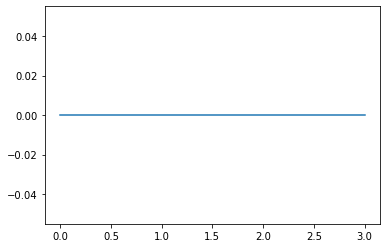

In [7]:
y = []
for i in tqdm.tqdm(range(1, len(env.detect_rate))):
    y.append(np.mean(env.detect_rate[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

100%|██████████| 4/4 [00:00<00:00, 20092.47it/s]


<AxesSubplot:>

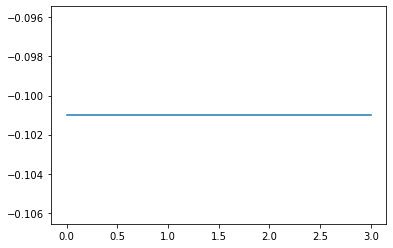

In [8]:
y = []
for i in tqdm.tqdm(range(1, len(env.rewards))):
    y.append(np.mean(env.rewards[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

In [9]:
env._rewards

[-0.002,
 -0.004,
 -0.006,
 -0.008,
 -0.01,
 -0.012,
 -0.014,
 -0.016,
 -0.018,
 -0.02,
 -0.022,
 -0.024,
 -0.026,
 -0.028,
 -0.03,
 -0.032,
 -0.034,
 -0.036,
 -0.038,
 -0.04,
 -0.042,
 -0.044,
 -0.046,
 -0.048,
 -0.05,
 -0.052,
 -0.054,
 -0.056,
 -0.058,
 -0.06,
 -0.062,
 -0.064,
 -0.066,
 -0.068,
 -0.07,
 -0.072,
 -0.074,
 -0.076,
 -0.078,
 -0.08,
 -0.082,
 -0.084,
 -0.086,
 -0.088,
 -0.09,
 -0.092,
 -0.094,
 -0.096,
 -0.098,
 -0.1,
 -0.102,
 -0.104,
 -0.106,
 -0.108,
 -0.11,
 -0.112,
 -0.114,
 -0.116,
 -0.118,
 -0.12,
 -0.122,
 -0.124,
 -0.126,
 -0.128,
 -0.13,
 -0.132,
 -0.134,
 -0.136,
 -0.138,
 -0.14,
 -0.142,
 -0.144,
 -0.146,
 -0.148,
 -0.15,
 -0.152,
 -0.154,
 -0.156,
 -0.158,
 -0.16,
 -0.162,
 -0.164,
 -0.166,
 -0.168,
 -0.17,
 -0.172,
 -0.174,
 -0.176,
 -0.178,
 -0.18,
 -0.182,
 -0.184,
 -0.186,
 -0.188,
 -0.19,
 -0.192,
 -0.194,
 -0.196,
 -0.198,
 -0.2]